# A quick refresh on the Microgenerator Architecture
![free-body-diagram](./img/fbd.png)
![microgenerator-body](./img/mcrg.png)

---


# The high-level concept
There are a couple of things you'll need to understand before you can begin simulating your microgenerator.

Each model consists of a few pieces:

1. The governing equations (most important)
2. A mechanical model
3. A electrical model
4. A coupling model

The governing equations are essentially your mathematical model of your entire microgenerator. You express your model as a set of differential equations, which will eventually be solved. This is what simulates your design. **Don't panic if this sounds confusing**. We'll cover the governing equations last, once we've gone through a simpler example first. Just understand that your governing equations essentially describe how the various components interact within your model.

So think of the governing equations as some math that we use to _arrange_ our various components. With that done, we need to define these components.

The mechanical model contains all the components related to the mechanical part of the system (eg. friction, the magnetic spring, the manget assembly, etc.)  
The electrical model contains all the components related to the electrical part of the system (eg. flux linkage, coil resistance and the load, etc.)  
The coupling model explains the feedback between the electrical and mechanical model (it models our Lorentz force).

Once you've defined these components, we assemble them into a `UnifiedModel`, and are then free to run our simulation and process the result.

Let's get started.

---

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

# Local imports
from unified_model import UnifiedModel
from unified_model import MechanicalModel
from unified_model import ElectricalModel
from unified_model import CouplingModel
from unified_model import evaluate
from unified_model import mechanical_components
from unified_model import electrical_components
from unified_model import governing_equations
from unified_model import pipeline

%matplotlib inline

# Getting help in Jupyter
Before we start for real, it's important to know how to get access to the documentation for functions inside a Jupyter Notebook.

The clearest way is to type out the name of the class or function, and put a `?` on the end, and then to run the cell. Let's do an example for the `print` function below:

In [2]:
print?

Docstring:
print(value, ..., sep=' ', end='\n', file=sys.stdout, flush=False)

Prints the values to a stream, or to sys.stdout by default.
Optional keyword arguments:
file:  a file-like object (stream); defaults to the current sys.stdout.
sep:   string inserted between values, default a space.
end:   string appended after the last value, default a newline.
flush: whether to forcibly flush the stream.
Type:      builtin_function_or_method


A lot of effort has been made to make sure the `unified_model` library is documented! So, for virtually every component of the library, you can get access to the help documentation in exactly the same way.

For example:

In [3]:
UnifiedModel?

Init signature: UnifiedModel()
Docstring:     
Unified model class

This class is used to solve your combined or unified electrical and
mechanical models.

Attributes
----------
mechanical_model : instance of `MechanicalModel`
    The mechanical model to use as part of the unified model.
electrical_model : instance of `ElectricalModel`
    The electrical model to use as part of the unified model.
coupling_model : instance of `CouplingModel`
    The electro-mechanical coupling to use as part of the unified model.
governing_equations: func
    The set of governing equations to solve using the unified model.
raw_solution : ndarray
    The raw post-pipeline output of the solution of the governing
    equations. Intended for debugging purposes.
    Note that the dimensions of `raw_solution` is reversed: each
    row represents all the values for each differential equation
    expressed in `y` by the governing equations.
post_processing_pipeline : dict
    Dict where keys are pipeline names 

This also extends to the various class functions / methods as well:

In [4]:
UnifiedModel.solve?

Signature: UnifiedModel.solve(self, t_start: 'float', t_end: 'float', y0: 'List[float]', t_eval: 'List[float]', t_max_step: 'float' = 1e-05) -> 'None'
Docstring:
Solve the unified model.

Parameters
----------
t_start : float
    The start time of the simulation.
t_end : float
    The end time of the simulation
y0 : ndarray
    The initial values of `y`, or the result vector that is passed
    to the governing equations.
t_eval : ndarray[float]
    Times at which to store the computed solution.
t_max_step : float, optional
    The maximum time step (in seconds) to be used when solving the
    unified model. Default value is 1e-5.

See Also
--------
scipy.integrate.solve_ivp : Function used to solve the governing
    equations of the unified model.
File:      ~/Nextcloud/nextcloud/PhD/Python/unified_model/unified_model/unified.py
Type:      function


So if you're ever stuck or confused -- remember you can use the help functionality!

---
---

With that out the way, let's get started for real.

# Prerequisites
Before we can simulate our model, we assume that we already have a some kind of excitation that is applied to a model. In this particular case, we'll be using measurements from an accelerometer that are stored in a .csv file.

It has the following shape (ignore the code for now -- we'll be going over it in the next section): 

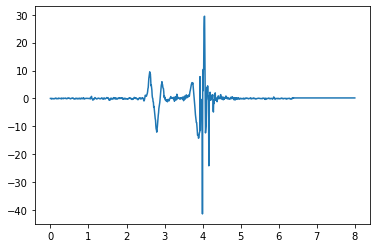

In [7]:
input_excitation = mechanical_components.AccelerometerInput(
    raw_accelerometer_input='../data/2019-05-23_C/A/log_03_acc.csv',  # Choose the accelerometer file we want to use
    accel_column='z_G',  
    time_column='time(ms)',
    accel_unit='g',
    time_unit='ms',
    smooth=True,
    interpolate=True
)

timesteps = np.linspace(0, 8, 1000)
acc = [input_excitation.get_acceleration(t) for t in timesteps]
plt.plot(timesteps, acc)
plt.show()

# Set the base model parameters

In [8]:
c = 1  # number of coils
m = 1  # number of magnets
l_m = 10  # length of the magnets in mm
dia_m = 10  # diameter of the magnets in mm
l_ccd = 0  # distance between centers of coils in mm
l_mcd = 0  # distance between centers of magnets in mm
c_c = 0.059  # location of center of first coil in m

# Start creating the various components

## Mechanical Model
We'll start by setting up the mechanical model. There are a couple things we need to set here:

1. The magnetic spring
2. The magnet assembly
3. The "impact" when the magnet assembly hits the top of the microgenerator
4. The damper that models the loss due to friction
5. The input acceleration / excitation

### Magnetic spring

In [10]:
def smoothing_filter(x_arr):
    return savgol_filter(x_arr, window_length=27, polyorder=5)

magnetic_spring = mechanical_components.MagneticSpringInterp(
    fea_data_file='../data/magnetic-spring/10x10alt.csv',
    magnet_length=l_m/1000,
    filter_callable=smoothing_filter
)

magnetic_spring  # You can preview components by evaluating them like this :)

MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function smoothing_filter at 0x7f2c859a9a60>)

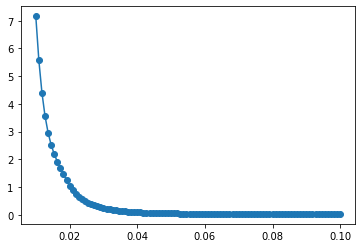

In [11]:
# Let's draw some plots just to be sure

z_arr = np.linspace(0.01, 0.1, 100)
force = [magnetic_spring.get_force(z) for z in z_arr]
plt.plot(z_arr, force, 'o-')  # Notice the little discontinuity! (ask me about this)

### Magnet Assembly

In [12]:
mag_assembly = mechanical_components.MagnetAssembly(
    m=m,
    l_m_mm=l_m,
    l_mcd_mm=0,
    dia_magnet=dia_m,
    dia_spacer=dia_m,
)

mag_assembly

TypeError: __init__() got an unexpected keyword argument 'n_magnet'

In [10]:
mag_assembly.get_mass()

0.005890486225480863

### Friction

In [11]:
damper = mechanical_components.ConstantDamper(0.030)
damper

ConstantDamper(damping_coefficient=0.03)

### "thunk" at the top
We model the magnet assembly impacting the top of the microgenerator body as a very strong mechanical spring that 
push but cannot pull.

In [12]:
mech_spring = mechanical_components.MechanicalSpring(
    position=110/1000,  # position of the microgenerator "top" (in metres)
    magnet_length=l_m/1000,
    damping_coefficient=0.5  # Controls how "lossy" the impact is.
) 

mech_spring

MechanicalSpring(position=0.11, magnet_length=0.01, strength=1000000000.0, damping_coefficient=0.5)

## Electrical Model
Next, we'll set up the electrical model. For this, we'll need:

1. The coil resistance
2. The load model
3. The rectification voltage drop
4. The flux model (and its derivative)

### Coil resistance

In [13]:
R_coil = 12.5  # Ohms

### Load

In [14]:
load = electrical_components.SimpleLoad(R=20)  # Ohms
load

SimpleLoad(R=20)

### Rectification Drop

In [15]:
v_rect_drop = 0.1  # Volts (depends on your Schottky diodes)

### Flux Model
The flux model is a _little_ trickier.

With the flux model, we actually need to fit it to some _data_.  
This data is simply a flux curve that we've simulated previously using some FEA software (at least in this example).

So here, we read in a .CSV file with our data, and then pass that through to the model to fit.  
In this example, we don't use a very sophisticated model (we simply interpolate between the values using a [smooth curve](https://en.wikipedia.org/wiki/B-spline)).

And then, just to be sure, we also draw some plots to make sure things look "correct".

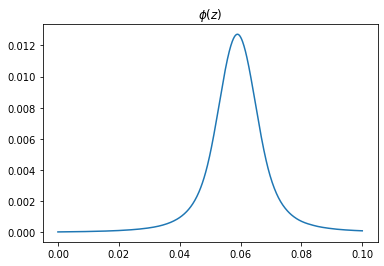

In [16]:
flux_model = electrical_components.FluxModelInterp(
    c=c,
    m=m,
    c_c=c_c,
    l_ccd=l_ccd,
    l_mcd=l_mcd
)

# But we still need to 'fit' the flux model to some data...
df = pd.read_csv('./data/fea-flux-curves/example_flux_curve.csv')
df.columns = ['time_ms', 'flux']  # Rename the columns to something more friendly
df['z'] = df['time_ms']*0.35/1000  # Get position of magnet by multiplying time by velocity (0.35m/s in this case)
df['flux'] = np.abs(df['flux'])

flux_model.fit(df['z'].values, df['flux'].values)
flux_model

# Let's draw a quick plot to make sure everything looks correct
test_z_values = np.linspace(0, 0.1, 10000)
model_phi_values = [flux_model.flux(z) for z in test_z_values]  # We'll check both the flux
model_dphi_values =[flux_model.dflux(z) for z in test_z_values]  # And also its derivative
plt.plot(test_z_values, model_phi_values)
plt.title('$\phi(z)$')
plt.show()

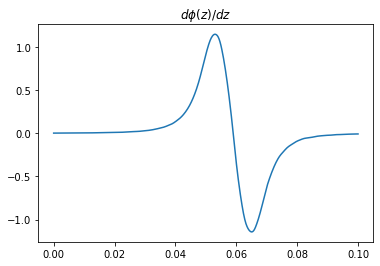

In [17]:
plt.plot(test_z_values, model_dphi_values, label='dflux/dz')
plt.title('$d \phi(z) /dz$')
plt.show()

### Coupling Model

In [18]:
coupling_model = CouplingModel().set_coupling_constant(1.)
coupling_model

CouplingModel(coupling_constant=1.0)

# Build the Unified Model
Now, we just assemble everything.

In [19]:
mechanical_model = MechanicalModel() \
    .set_damper(damper) \
    .set_magnet_assembly(mag_assembly) \
    .set_magnetic_spring(magnetic_spring) \
    .set_mechanical_spring(mech_spring) \
    .set_input(input_excitation)

In [20]:
electrical_model = ElectricalModel() \
    .set_coil_resistance(R_coil) \
    .set_rectification_drop(v_rect_drop) \
    .set_load_model(load) \
    .set_flux_model(flux_model.flux_model, flux_model.dflux_model) \

In [21]:
unified_model = UnifiedModel() \
    .set_mechanical_model(mechanical_model) \
    .set_electrical_model(electrical_model) \
    .set_coupling_model(coupling_model) \
    .set_post_processing_pipeline(pipeline.clip_x2, name='clip tube velocity') \
    .set_governing_equations(governing_equations.unified_ode)  # Here we set our governing equations for my particular microgenerator. We'll go over this a bit later.

Notice that we've added a post-processing pipeline that clips the tube velocity.
This is a requirement due to the quirks of our particular differential equation solver we use and how the current governing equation is written. Essentially, in the governing equation we prevent the tube from _going through the floor_, clipping the value to 0 if it does so. The solver doesn't know how to interpret this behaviour, and so gives a bad response. This pipeline corrects for this.

**Ask me about the post-processing pipeline in person if this is confusing**

---

### Let's make sure everything looks good:

In [22]:
print(mechanical_model)

Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(./data/magnetic-spring/10x10alt.csv, <function smoothing_filter at 0x7f02052ef8c8>)
      mechanical_spring: MechanicalSpring(position=0.11, magnet_length=0.01, strength=1000000000.0, damping_coefficient=0.5)
      magnet_assembly: MagnetAssembly(n_magnet=1, l_m=10, l_mcd=0, dia_magnet=10, dia_spacer=10)
      damper: ConstantDamper: 
      damping_coefficient: 0.03
      input_: <unified_model.mechanical_components.input_excitation.accelerometer.AccelerometerInput object at 0x7f020a2f3390>


In [23]:
print(electrical_model)

Electrical Model: 
      flux_model: <numba.jitclass.boxing.FastInterpolator object at 0x7f0205961350>
      dflux_model: <numba.jitclass.boxing.FastInterpolator object at 0x7f020592bdb0>
      coil_resistance: 12.5
      rectification_drop: 0.1
      load_model: SimpleLoad: 20 Ohms


In [24]:
print(unified_model)

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(./data/magnetic-spring/10x10alt.csv, <function smoothing_filter at 0x7f02052ef8c8>)
      mechanical_spring: MechanicalSpring(position=0.11, magnet_length=0.01, strength=1000000000.0, damping_coefficient=0.5)
      magnet_assembly: MagnetAssembly(n_magnet=1, l_m=10, l_mcd=0, dia_magnet=10, dia_spacer=10)
      damper: ConstantDamper: 
      damping_coefficient: 0.03
      input_: <unified_model.mechanical_components.input_excitation.accelerometer.AccelerometerInput object at 0x7f020a2f3390>
  electrical_model: Electrical Model: 
      flux_model: <numba.jitclass.boxing.FastInterpolator object at 0x7f0205961350>
      dflux_model: <numba.jitclass.boxing.FastInterpolator object at 0x7f020592bdb0>
      coil_resistance: 12.5
      rectification_drop: 0.1
      load_model: SimpleLoad: 20 Ohms
  coupling_model: CouplingModel(coupling_constant=1.0)
  governing_equations: <function unified_ode a

# Everything looks good. Let's run our simulation

Our simulation just needs one extra thing though, the initial conditions. `x1` to `x5` are defined by the governing equations (we'll touch on them soon!).

In [26]:
y0 = [
    0.0,  # x1 at t=0 -> tube displacement in m
    0.0,  # x2 at t=0 -> tube velocity in m/s
    0.05, # x3 at t=0 -> magnet displacement in m
    0.0,  # x4 at t=0 -> magnet velocity in m/s
    0.0   # x5 at t=0 -> flux linkage in 
]

unified_model.solve(  # This can take a little while...
    t_start=0,
    t_end=8,
    y0=y0,  # Initial conditions we defined above
    t_max_step=1e-3,  # Don't make this too big (low accuracy) or small (long run time)
    method='BDF'
)

## Let's fetch our results
Retrieving our results is quite a fun process, and is probability a little different to what you're used to. The docstring hopefully explains it clearly enough:

In [29]:
unified_model.get_result?

Signature: unified_model.get_result(**kwargs) -> pandas.core.frame.DataFrame
Docstring:
Get a dataframe of the results using expressions.

*Any* reasonable expression is possible. You can refer to each of the
differential equations that is represented by the governing equations
using the letter 'x' with the number appended. For example `x1` refers
to the first differential equation, `x2` to the second, etc.

Each expression is available as a column in the returned pandas
dataframe, with the column name being the key of the passed expression.

Parameters
----------
**kwargs
    Each key is the name of the column of the returned dataframe.
    Each value is the expression to be evaluated.

Returns
-------
pandas dataframe
    Output dataframe containing the evaluated expressions.

See Also
--------
unified_model.utils.utils.parse_output_expression : helper function
    that contains the parsing logic.

Example
--------
>>> # Here we use previously-built and solved unified model
>>> unifi

---
## Fetching the solution

I've chosen a few of the typical metrics you'd likely need to look at.

In [30]:
result = unified_model.get_result(
    time='t',  # time,
    rel_pos_mag='x3-x1',  # Relative position of magnet in m
    rel_vel_mag='x4-x2',  # Relative velocity of magnet in m
    flux='x5',  # Flux linkage
    emf='g(t, x5)'  # EMF, which is the gradient, with respect to time, of the flux. In volts.
)

result.head()

,time,rel_pos_mag,rel_vel_mag,flux,emf
0,0.000,0.050000,0.000000,0.0,0.0
1,0.001,0.050000,-0.000878,0.0,0.0
2,0.002,0.049998,-0.001752,0.0,0.0
3,0.003,0.049996,-0.002620,0.0,0.0
4,0.004,0.049993,-0.003484,0.0,0.0


We can than then draw up a few plots, using whichever plotting library you like (I like `plotnine`, but use whatever you prefer or find easiest -- probably `matplotlib` if you're newer to Python)

In [31]:
from plotnine import *

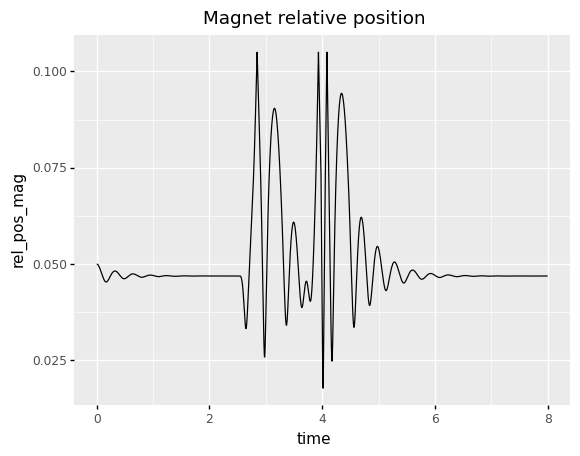

<ggplot: (8752698725324)>

In [32]:
p = ggplot(aes(x='time', y='rel_pos_mag'), result)
p + geom_line() + ggtitle('Magnet relative position')

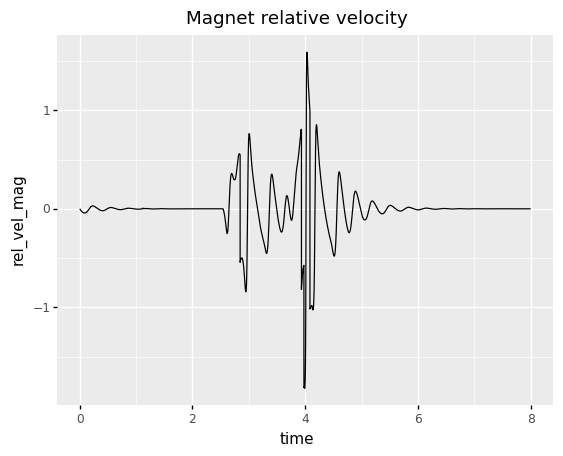

<ggplot: (-9223363284156123083)>

In [33]:
p = ggplot(aes(x='time', y='rel_vel_mag'), result)
p + geom_line() + ggtitle('Magnet relative velocity')

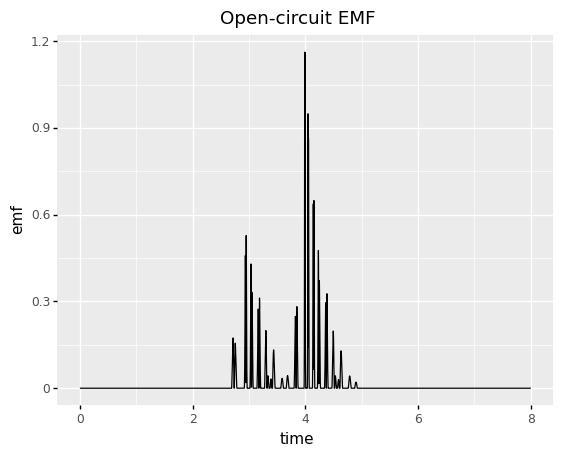

<ggplot: (8777451931589)>

In [31]:
p = ggplot(aes(x='time', y='emf'), result)
p + geom_line() + ggtitle('Open-circuit EMF')

# Calculating Metrics
Once you've finished running your simulation, often you'll wish to calculate some metrics on the prediction. Two types of metrics can be calculated:

1. Metrics that _don't_ depend on groundtruth data (called 'calculation metrics')
2. Metrics that _do_ depend on groundtruth data (called 'score metrics')

We'll cover both of these cases below.

## Calculation metrics
As mentioned before, these calculation metrics don't depend on groundtruth data -- they simply calculate a metric based on the prediction values. A good example is calculating the RMS of the predicted open-source EMF, but, as you'll soon see, you can choose any metric you wish.

Let's first demonstrate how to calculate these metrics, and then explain how it works:

In [107]:
def calculate_max(arr):
    return max(arr)

def calculate_min(arr):
    return min(arr)

def calculate_rms(arr):
    square = arr**2
    sum_square = np.sum(square)
    sqrt_sum_square = np.sqrt(sum_square / len(arr))
    return sqrt_sum_square

metric_dict = {
    'maximum_y_diff': calculate_max,
    'minimum_y_diff': calculate_min,
}

# First calculate metrics on the relative displacement between the tube (x1) and the magnet assembly (x3)
# See the "Fetching results" section above if you're unfamiliar with the "prediction expression" concept.
calculated_mech_metrics = unified_model.calculate_metrics(prediction_expr='x3-x1', metric_dict=metric_dict)
calculated_mech_metrics

{'maximum_y_diff': 0.10500167355352841, 'minimum_y_diff': 0.01807191992452532}

In [108]:
# Next, let's calculate metrics on the open-circuit EMF of the system
metric_dict = {
    'oc_emf_v': calculate_rms
}

calculated_elec_metrics = unified_model.calculate_metrics(prediction_expr='g(t,x5)', metric_dict=metric_dict)
calculated_elec_metrics

{'oc_emf_v': 0.07477352666606242}

As you can see, in order to calculate metrics, you to specify the prediction expression and a dictionary, where the key is the name you wish to give the metric, and the value a function that accepts an array of values and returns the metric.

## Score metrics
If you wish to calculate metrics that do depend on groundtruth data, things get a little more complicated (but not by much!). For now, I am considering it beyond the scope of this particular notebook, since it requires a discussion regarding how to correctly process groundtruth data for accurate scoring.

But the classes you need to be aware of is the `MechanicalSystemEvaluator` and `LabeledVideoProcessor` (for processing and scoring groundtruth mechanical data) and the `ElectricalSystemEvaluator` and `AdcProcessor` (for processing and scoring the groundtruth electrical data).

All the classes are fully documented, and shouldn't be too difficult to figure out, but send me an email if you get stuck:

In [109]:
evaluate.LabeledVideoProcessor?

Init signature: evaluate.LabeledVideoProcessor(mm, seconds_per_frame, pixel_scale=None)
Docstring:     
Post-processor for labeled magnet-assembly data.

Attributes
----------
mm : float
    Height of the moving magnet assembly in mm.
seconds_per_frame : float
    Number of seconds per frame / datapoint.
    This is typically found in the `subsampled_seconds_per_frame` key
    of the generated .DONE file when using the OpenCV-based CLI
    helper script.
pixel_scale : float, optional
    The pixel scale to use (in mm per pixel). This value will override
    the recorded pixel values in the groundtruth_dataframe.
    Default value is None.

Methods
-------
fit_transform(groundtruth_dataframe, impute_missing_values)
    Process and transform groundtruth video measurements.
Init docstring:
Constructor.

Parameters
----------
mm : float
    Height of the moving magnet assembly in mm.
seconds_per_frame : float
    Number of seconds per frame / datapoint.
    This is typically found in the `

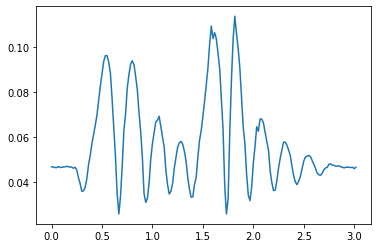

In [110]:
lvp = evaluate.LabeledVideoProcessor(
    mm=10,
    seconds_per_frame=1/60,
    pixel_scale=0.154508
)

mag_center_pos, timestamps = lvp.fit_transform(
    groundtruth_dataframe=pd.read_csv('./data/2019-05-23_C/A/a003_transcoded_subsampled_labels_2019-10-31-10:13:15.csv'),
    impute_missing_values=True
)

plt.plot(timestamps, mag_center_pos)

In [111]:
evaluate.MechanicalSystemEvaluator?

Init signature:
evaluate.MechanicalSystemEvaluator(
    y_target: numpy.ndarray,
    time_target: numpy.ndarray,
    metrics: Dict[str, Callable],
    clip: bool = True,
    warp: bool = False,
) -> None
Docstring:     
Evaluate the accuracy of a mechanical system model's output

Parameters
----------
y_target : ndarray
    The target values that the mechanical system model is
    attempting to predict. This is the "ground truth" that the
    prediction will be compared against.
time_target : ndarray
    The corresponding timestamps of the values in `y_target`
metrics : Dict[str, Callable]
    Metrics to compute on the interpolated predicted and target data.
    Keys determine the "name" of the metric and values must be a
    Callable that is used to compute the metric. Each Callable must
    accept arguments (arr_predict, arr_target) as input, where
    `arr_predict` and `arr_target` are numpy arrays that contain the
    predicted values and target values, respectively. The return val

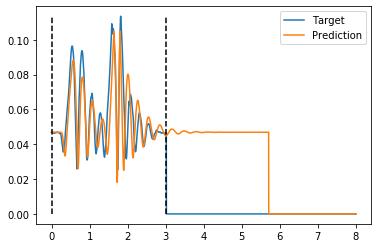

In [112]:
mse = evaluate.MechanicalSystemEvaluator(
    y_target=mag_center_pos,
    time_target=timestamps,
    metrics=None,
    clip=True
)

mse.fit(
    y_predict=result['rel_pos_mag'].values,
    time_predict=result['time'].values
)

mse.poof()